In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#!pip install torchaudio
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
import os
default_dir = os.getcwd()
print(default_dir)
os.chdir(f'./output/')
labels = [name for name in os.listdir('.') if os.path.isdir(name)]
# back to default directory
os.chdir(default_dir)
print(f'Total Labels: {len(labels)}')
print(f'Label Names: {labels}')

/home/ec2-user/SageMaker/audioset-processing
Total Labels: 4
Label Names: ['Male speech, man speaking', 'Child speech, kid speaking', 'Female speech, woman speaking', '.ipynb_checkpoints']


In [4]:
filename = "./output/Child speech, kid speaking/-_eV43RJGC8_320.wav"
waveform, sample_rate = torchaudio.load(filepath=filename, num_frames=3)
print(f'waveform tensor:{waveform}')
waveform, sample_rate = torchaudio.load(filepath=filename, num_frames=3)
print(waveform)
waveform, sample_rate = torchaudio.load(filepath=filename)
print(waveform)

waveform tensor:tensor([[0.0908, 0.0838, 0.0619],
        [0.0908, 0.0838, 0.0619]])
tensor([[0.0908, 0.0838, 0.0619],
        [0.0908, 0.0838, 0.0619]])
tensor([[ 0.0908,  0.0838,  0.0619,  ..., -0.0161, -0.0145, -0.0140],
        [ 0.0908,  0.0838,  0.0619,  ..., -0.0161, -0.0146, -0.0142]])


In [5]:
def plot_audio(filename):
    waveform, sample_rate = torchaudio.load(filename)

    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))

    plt.figure()
    plt.plot(waveform.t().numpy())

    return waveform, sample_rate

Shape of waveform: torch.Size([2, 159888])
Sample rate of waveform: 16000


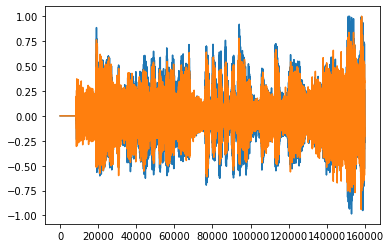

In [6]:
filename = "./output/Child speech, kid speaking/-1_9NFiOw-I_0.wav"
waveform, sample_rate = plot_audio(filename)
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [7]:
import subprocess
import sys
import threading
!pip install --upgrade torch torchvision
import torchvision

from transforms import tensor_transform
from utils import load_data

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchaudio/functional/functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [8]:
directory = "./output"
data = load_data(str(directory), transforms=tensor_transform, num_workers=1,batch_size= 12)


3479
1750
1750
Size of train dataset:  6979


In [9]:
torch.cuda.memory_summary(device=None, abbreviated=True)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| GPU reserved memory   |       0 B  |       0 B  |       0 B  |       0 B  |\n|--------------------------------------------------

In [10]:
import torch
from torch.nn import functional as f

def split_tensor(tensor, tile_size=16, channel=1):
    mask = torch.ones_like(tensor)
    # use torch.nn.Unfold
    stride  = tile_size//1 
    stride  = 10
    unfold  = nn.Unfold(kernel_size=(tile_size, tile_size), stride=stride)
    # Apply to mask and original image
    mask_p  = unfold(mask)
    patches = unfold(tensor)

    patches = patches.reshape(channel, tile_size, tile_size, -1).permute(3, 0, 1, 2)
    if tensor.is_cuda:
        patches_base = torch.zeros(patches.size(), device=tensor.get_device())
    else: 
        patches_base = torch.zeros(patches.size())

    tiles = []
    for t in range(patches.size(0)):
         tiles.append(patches[[t], :, :, :])
    return tiles, mask_p, patches_base, (tensor.size(2), tensor.size(3))




In [11]:
'''
for i,j, k in data['train']:
    print(i.size())
#     patches = spec_to_patches(i)
    tile_tensors, mask_t, base_tensor, t_size = split_tensor(i)
    # show small patches
    print("base", base_tensor.size())
    for i in range(len(tile_tensors)):
        print(f'the current is {i}')
        print(tile_tensors[i].cpu().squeeze(0).size())

!pip install pytorch-pretrained-bert
from pytorch_pretrained_bert.tokenization import BertTokenizer
import numpy as np

a = np.zeros((1,768), dtype = np.unicode_)
a[0,:] = '[CLS]'
token_layer = torch.from_numpy(a)
#token_layer = token_layer.fill_('[CLS]')

for img, j, k in data['train']:
    conv = nn.Conv2d(1, 768, 16, 10)
    img = conv(img).reshape(-1, 948).transpose(0,1)
    img = torch.cat((token_layer, img))
    print(img.size())
    
'''
    

'\nfor i,j, k in data[\'train\']:\n    print(i.size())\n#     patches = spec_to_patches(i)\n    tile_tensors, mask_t, base_tensor, t_size = split_tensor(i)\n    # show small patches\n    print("base", base_tensor.size())\n    for i in range(len(tile_tensors)):\n        print(f\'the current is {i}\')\n        print(tile_tensors[i].cpu().squeeze(0).size())\n\n!pip install pytorch-pretrained-bert\nfrom pytorch_pretrained_bert.tokenization import BertTokenizer\nimport numpy as np\n\na = np.zeros((1,768), dtype = np.unicode_)\na[0,:] = \'[CLS]\'\ntoken_layer = torch.from_numpy(a)\n#token_layer = token_layer.fill_(\'[CLS]\')\n\nfor img, j, k in data[\'train\']:\n    conv = nn.Conv2d(1, 768, 16, 10)\n    img = conv(img).reshape(-1, 948).transpose(0,1)\n    img = torch.cat((token_layer, img))\n    print(img.size())\n    \n'

In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
!pip install einops
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce


In [13]:
# class PatchEmbedding(nn.Module):
#     def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, stride: int = 10):
#         self.patch_size = patch_size
#         super().__init__()
#         self.projection = nn.Sequential(
#             nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=stride),
#             Rearrange('b e (h) (w) -> b (h w) e'),
#         )
        
#         self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
#         self.positions = nn.Parameter(torch.randn((949, emb_size)))

        
#     def forward(self, x: Tensor) -> Tensor:
#         b, _, _, _ = x.shape
#         x = self.projection(x)
#         cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
#         # prepend the cls token to the input
#         x = torch.cat([cls_tokens, x], dim=1)
#         x = x + self.positions
#         return x
    

    
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = (224, 224)):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride= 16),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn(((img_size[0] // patch_size) * (img_size[1] // patch_size) + 1, emb_size)))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 12, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    

In [15]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [16]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [17]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


In [18]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [19]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 2):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes),
            #nn.Sigmoid()
        )

In [33]:

class AST(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = (224,224),
                depth: int = 12,
                n_classes: int = 2,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
        

In [34]:
!pip3 install vit_pytorch

import torch
from vit_pytorch import ViT

v = ViT(
    image_size = 800,
    patch_size = 16,
    num_classes = 2,
    dim = 768,
    depth = 12,
    heads = 12,
    mlp_dim = 3072,
    dropout = 0.1,
    emb_dropout = 0.1
)

# MODEL SUMMARY

In [35]:
!pip3 install torchsummary
from torchsummary import summary
summary(AST().cuda(), (3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6         [-1, 12, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 19

# TENSORBOARD

In [ ]:
!pip install tensorboard 

%load_ext tensorboard
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

%tensorboard --logdir logs

# LEARNING RATE SCHEDULER AND LOAD WEIGHTS

In [36]:
import torch.optim as optim
!pip3 install tqdm
from tqdm import tqdm


device =  torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
num_epochs = 25
model = AST().to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(AST().parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# TRAINING

In [37]:
from torchvision import transforms

for epoch in range(num_epochs):  
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    running_loss = 0.0
    running_corrects = 0

    if epoch > 10:
        scheduler.step()
        
    for i, (img, label) in enumerate(data['train']):
        #img = torch.zeros((12, 3, 224, 224))
        img = torch.cat((img,img,img), 1)
        trans = transforms.Compose([transforms.Resize((224, 224))])
        img = trans(img)
        print(img.shape)
        img = img.to(device)
    
        label = label.to(device)
       
        # zero the parameter gradients
  
        optimizer.zero_grad()
        
        # forward + backward + optimize
        
        outputs = model(img)
        
        classified = torch.argmax(outputs, dim = 1).float()
        label = label.float()
        classified.requires_grad = True
        label.requires_grad = False
        print(label)
        print(classified)
        loss = criterion(classified.float(), label.float())
        print(loss)
        
       # writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_corrects += torch.sum(classified == label.data)
        
    epoch_loss = running_loss / len(data['train'])
    epoch_acc = running_corrects.double() / len(data['train'])
        
    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        #print('{} Loss: {:.4f}'.format(i, loss))
        

print('Finished Training')



Epoch 0/24
----------
torch.Size([12, 3, 224, 224])
tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)
tensor(25., device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
torch.Size([12, 3, 224, 224])
tensor([1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)
tensor(41.6667, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
torch.Size([12, 3, 224, 224])
tensor([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)
tensor(33.3333, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
torch.Size([12, 3, 224, 224])
tensor([1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

KeyboardInterrupt: 

# TRIAL

In [27]:
!pip3 install vit_pytorch

import torch
from vit_pytorch import ViT

v = ViT(
    image_size = 800,
    patch_size = 16,
    num_classes = 2,
    dim = 768,
    depth = 12,
    heads = 12,
    mlp_dim = 3072,
    dropout = 0.1,
    emb_dropout = 0.1
)

img = torch.randn(1, 3, 128, 800)

preds = v(img) # (1, 1000)
print(preds)

tensor([[0.8181, 0.6104]], grad_fn=<AddmmBackward>)
